# **Primer Parcial**

dataset seleccionado:  *https://www.kaggle.com/datasets/aayushmishra1512/twitchdata*

"Numero 12 de los que se me asigno en el exel"



**proposito de los 2 modelos:** *Inferir si un Streamer tiene mas de 318k de seguidores considerando las otras columnas de datset*


In [76]:
import numpy as np
from matplotlib import pyplot
import numpy as np
import pandas as pd  # Asegúrate de importar pandas
%matplotlib inline

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Carga y preprocesamiento de datos**

In [78]:
file_path = '/content/drive/MyDrive/Inteligencia Artificial/PrimerParcial/twitchdata-update.csv'

# Cargar los datos con pandas (se asume que el CSV tiene encabezado)
df = pd.read_csv(file_path)
print("Ejemplo de 5 filas del dataset original:")
print(df.head())

# Eliminar la columna "Channel"
df = df.drop(columns=["Channel"])

# Convertir las columnas "Partnered" y "Mature" de true/false a 1/0
df["Partnered"] = df["Partnered"].astype(str).str.strip().str.lower().map({'true': 1, 'false': 0})
df["Mature"] = df["Mature"].astype(str).str.strip().str.lower().map({'true': 1, 'false': 0})

# Función para convertir la columna "Followers"
def convert_followers(x):
    x = str(x).strip().lower()
    if 'k' in x:
        return float(x.replace('k','')) * 1000
    else:
        return float(x)

# Convertir la columna "Followers" y binarizar según el umbral de 318k
df["Followers"] = df["Followers"].apply(convert_followers)
df["Followers_binary"] = (df["Followers"] >= 318000).astype(int)

# Convertir la columna "Language" a enteros mediante un mapeo
# Primero se extraen los idiomas únicos y se asigna un entero a cada uno.
unique_languages = df["Language"].unique()
language_map = {lang: idx for idx, lang in enumerate(unique_languages)}
df["Language_int"] = df["Language"].map(language_map)

# Si ya no necesitas la columna original de texto, puedes eliminarla:
df = df.drop(columns=["Language"])

print("\nEjemplo de 5 filas después de las conversiones:")
print(df.head())

# Ahora, al construir la matriz de características, utiliza "Language_int" en lugar de "Language".
# Por ejemplo, si las columnas numéricas a usar son:
numeric_columns = [
    "Watch time(Minutes)", "Stream time(minutes)", "Peak viewers",
    "Average viewers", "Followers gained", "Views gained",
    "Partnered", "Mature", "Language_int"  # Incluimos el idioma ya codificado.
]
numeric_features = df[numeric_columns].values.astype(float)


# Normalización manual de características numéricas
numeric_features = (numeric_features - np.mean(numeric_features, axis=0)) / np.std(numeric_features, axis=0)

# Concatenar una columna de 1 (bias) al inicio
X = np.concatenate([np.ones((df.shape[0], 1)), numeric_features], axis=1)
y = df["Followers_binary"].values

# División en train (80%) y test (20%)
np.random.seed(42)
indices = np.random.permutation(X.shape[0])
train_size = int(0.8 * X.shape[0])
X_train, X_test = X[indices[:train_size]], X[indices[train_size:]]
y_train, y_test = y[indices[:train_size]], y[indices[train_size:]]

print("\nDimensión de X_train:", X_train.shape)
print("Distribución del target (Followers_binary):")
print(f"- Target 0: {np.sum(y == 0)} casos")
print(f"- Target 1: {np.sum(y == 1)} casos")

Ejemplo de 5 filas del dataset original:
    Channel  Watch time(Minutes)  Stream time(minutes)  Peak viewers  \
0     xQcOW           6196161750                215250        222720   
1  summit1g           6091677300                211845        310998   
2    Gaules           5644590915                515280        387315   
3  ESL_CSGO           3970318140                517740        300575   
4      Tfue           3671000070                123660        285644   

   Average viewers  Followers  Followers gained  Views gained  Partnered  \
0            27716    3246298           1734810      93036735       True   
1            25610    5310163           1370184      89705964       True   
2            10976    1767635           1023779     102611607       True   
3             7714    3944850            703986     106546942       True   
4            29602    8938903           2068424      78998587       True   

   Mature    Language  
0   False     English  
1   False     English

**2. Funciones básicas**

In [79]:
def sigmoid(z):
    """Función sigmoide para la regresión logística"""
    return 1 / (1 + np.exp(-z))

def calcularCosto(theta, X, y):
    """Función de costo para regresión logística"""
    m = y.size
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    return J

def descensoGradiente(theta, X, y, alpha, num_iters):
    """Implementación del descenso de gradiente"""
    m = y.shape[0]
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)
        J_history.append(calcularCosto(theta, X, y))
    return theta, J_history


**3. Entrenamiento del modelo**

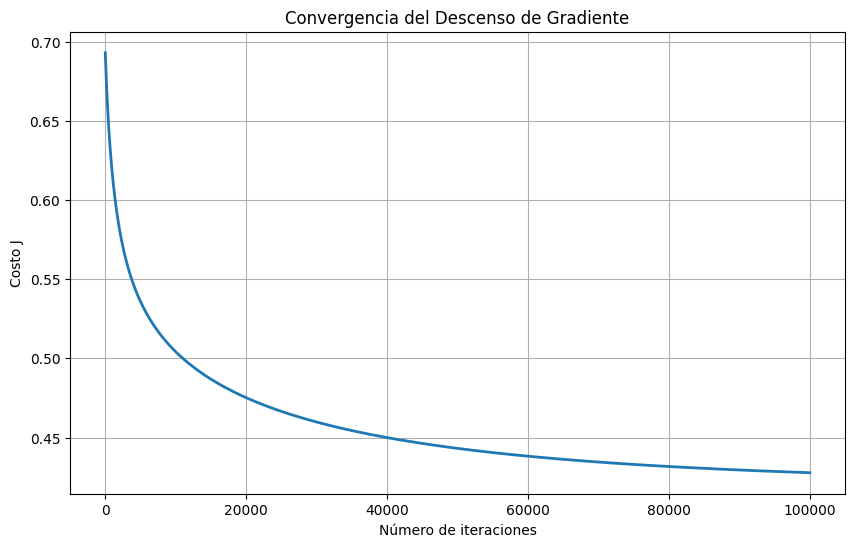

In [80]:
# Hiperparámetros
alpha = 0.001  # Tasa de aprendizaje
num_iters = 100000  # Iteraciones

# Inicializar theta y entrenar
theta = np.zeros(X_train.shape[1])
theta, J_history = descensoGradiente(theta, X_train, y_train, alpha, num_iters)

# Gráfica de convergencia
pyplot.figure(figsize=(10, 6))
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Número de iteraciones')
pyplot.ylabel('Costo J')
pyplot.title('Convergencia del Descenso de Gradiente')
pyplot.grid(True)
pyplot.show()


**4. Evaluación del modelo**

In [81]:
def predict(theta, X, threshold=0.5):
    """Función de predicción"""
    return sigmoid(X.dot(theta.T)) >= threshold

# Precisión en entrenamiento y prueba
train_accuracy = np.mean(predict(theta, X_train) == y_train) * 100
test_accuracy = np.mean(predict(theta, X_test) == y_test) * 100

print(f"Precisión en entrenamiento: {train_accuracy:.2f}%")
print(f"Precisión en prueba: {test_accuracy:.2f}%")


Precisión en entrenamiento: 79.38%
Precisión en prueba: 79.50%


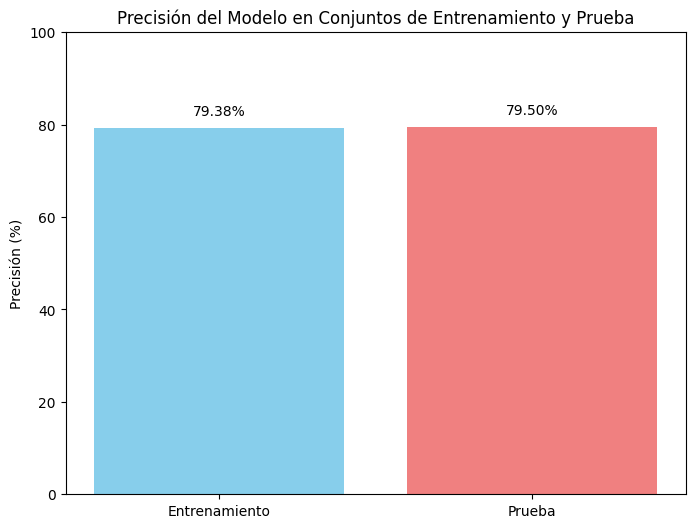

In [93]:
# Gráfica de precisión en entrenamiento y prueba
plt.figure(figsize=(8, 6))
plt.bar(['Entrenamiento', 'Prueba'], [train_accuracy, test_accuracy], color=['skyblue', 'lightcoral'])
plt.ylabel('Precisión (%)')
plt.title('Precisión del Modelo en Conjuntos de Entrenamiento y Prueba')
plt.ylim(0, 100)  # Ajustar el límite del eje y para una mejor visualización
for i, v in enumerate([train_accuracy, test_accuracy]):
    plt.text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom') # Agregar valores encima de las barras
plt.show()


## **RED NEURONAL**

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


**1. Preparación de datos (usando X e y del preprocesamiento anterior)**

In [83]:
# Convertir a tensores de PyTorch
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).reshape(-1, 1)

# Dividir en train (80%) y validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


**2. Definición del modelo MLP**

In [101]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size):
        super(SimpleMLP, self).__init__()
        # Definir las 5 capas ocultas con tamaños decrecientes
        self.fc1 = nn.Linear(input_size, 1024)  # Capa 1: de input_size a 1024
        self.fc2 = nn.Linear(1024, 512)         # Capa 2: de 1024 a 512
        self.fc3 = nn.Linear(512, 256)          # Capa 3: de 512 a 256
        self.fc4 = nn.Linear(256, 128)          # Capa 4: de 256 a 128
        self.fc5 = nn.Linear(128, 64)           # Capa 5: de 128 a 64
        # Capa de salida: de 64 a 1
        self.out = nn.Linear(64, 1)
        # Funciones de activación
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.sigmoid(self.out(x))
        return x

# Hiperparámetros
input_size = X_train.shape[1]
learning_rate = 0.001
epochs = 2000
batch_size = 64

# Inicializar modelo, criterio de pérdida y optimizador
model = SimpleMLP(input_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

**3. Entrenamiento y validación**

In [102]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Función para calcular accuracy
def calculate_accuracy(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    return (y_pred == y_true).float().mean()

for epoch in range(epochs):
    # Entrenamiento
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        # Obtener batch
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += calculate_accuracy(labels, outputs)

    # Calcular métricas de entrenamiento
    train_loss /= (len(X_train) / batch_size)
    train_acc /= (len(X_train) / batch_size)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validación
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_acc = calculate_accuracy(y_val, val_outputs)

        val_losses.append(val_loss.item())
        val_accs.append(val_acc.item())

    # Log cada 5 épocas
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')


Epoch [5/2000], Train Loss: 0.7212, Val Loss: 0.6937, Train Acc: 0.5225, Val Acc: 0.5000
Epoch [10/2000], Train Loss: 0.7211, Val Loss: 0.6937, Train Acc: 0.5225, Val Acc: 0.5000
Epoch [15/2000], Train Loss: 0.7210, Val Loss: 0.6936, Train Acc: 0.5225, Val Acc: 0.5000
Epoch [20/2000], Train Loss: 0.7209, Val Loss: 0.6935, Train Acc: 0.5225, Val Acc: 0.5000
Epoch [25/2000], Train Loss: 0.7208, Val Loss: 0.6934, Train Acc: 0.5225, Val Acc: 0.5000
Epoch [30/2000], Train Loss: 0.7206, Val Loss: 0.6934, Train Acc: 0.5225, Val Acc: 0.5000
Epoch [35/2000], Train Loss: 0.7205, Val Loss: 0.6933, Train Acc: 0.5225, Val Acc: 0.5000
Epoch [40/2000], Train Loss: 0.7204, Val Loss: 0.6932, Train Acc: 0.5225, Val Acc: 0.5000
Epoch [45/2000], Train Loss: 0.7203, Val Loss: 0.6931, Train Acc: 0.5225, Val Acc: 0.5000
Epoch [50/2000], Train Loss: 0.7202, Val Loss: 0.6931, Train Acc: 0.5225, Val Acc: 0.5000
Epoch [55/2000], Train Loss: 0.7201, Val Loss: 0.6930, Train Acc: 0.5225, Val Acc: 0.5000
Epoch [60/2

**4. Gráficas de pérdida y precisión**

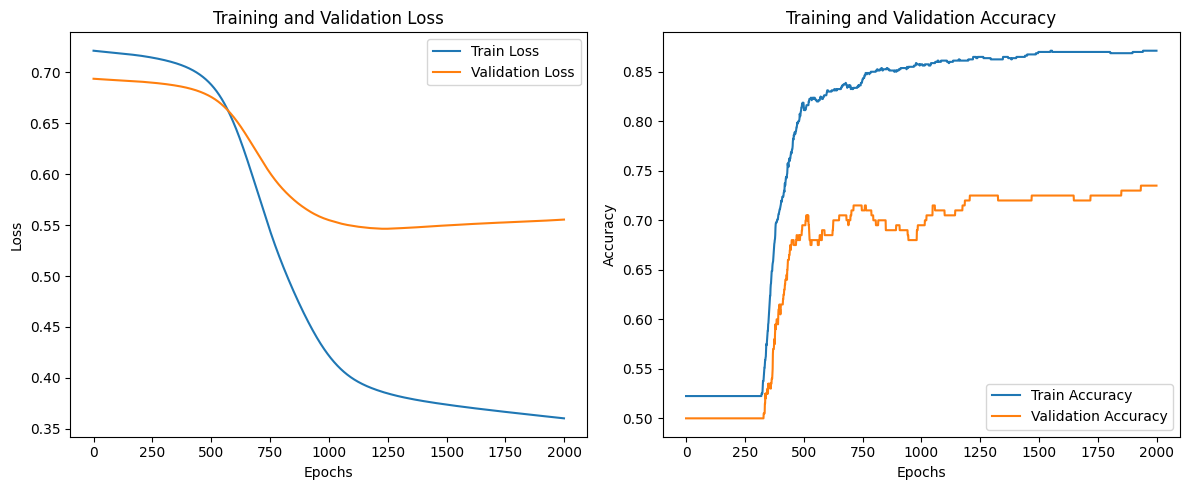

In [103]:
plt.figure(figsize=(12, 5))

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfica de precisión
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



**5. Evaluación final**

In [104]:
model.eval()
with torch.no_grad():
    # Calcular precisión final
    y_pred = model(X_val)
    y_pred_class = (y_pred > 0.5).float()
    final_acc = (y_pred_class == y_val).float().mean()

print(f'\nPrecisión final en validación: {final_acc.item():.4f}')


Precisión final en validación: 0.7350
